In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from cellpose import io
from liams_funcs import *
from features import *
from pytorch import *

import pandas as pd
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
control_dir = '../control_images/'
penetramax_dir = '../penetramax_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
penetramax_fnames = [penetramax_dir + fname for fname in os.listdir(penetramax_dir)]

In [4]:
#ds = Dataset(control_fnames, penetramax_fnames)
#_ = ds.createImageDataset(final_size=224)

cell_data = LoadImageDataset('pytorch_dataset/cells/')
nucleus_data = LoadImageDataset('pytorch_dataset/nuclei/')

In [5]:
from torch.utils.data import DataLoader, random_split

train_data, val_data = random_split(nucleus_data, [0.1, 0.9])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [11]:
n_epochs = 5
epochs = np.arange(0, n_epochs+0.5, dtype=int)
times = np.linspace(n_epochs, 0, len(train_dataloader), endpoint=False)[::-1]

clf_2k = Resnet18(train_layers=2).to(device)
clf_500k = Resnet18(train_layers=4).to(device)
clf_3M = Resnet18(train_layers=6).to(device)

In [21]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

clf = clf_2k
loss_fn = CrossEntropyLoss()
opt = Adam(clf.parameters(), lr=1e-5)

train_losses = []
val_losses = [get_loss(clf, val_dataloader, loss_fn)]

for _ in range(n_epochs):
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = clf(X)
        loss = loss_fn(y_pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_losses.append(loss.item())
    val_losses.append(get_loss(clf, val_dataloader, loss_fn))

  2%|▏         | 5/272 [00:15<13:49,  3.11s/it]


KeyboardInterrupt: 

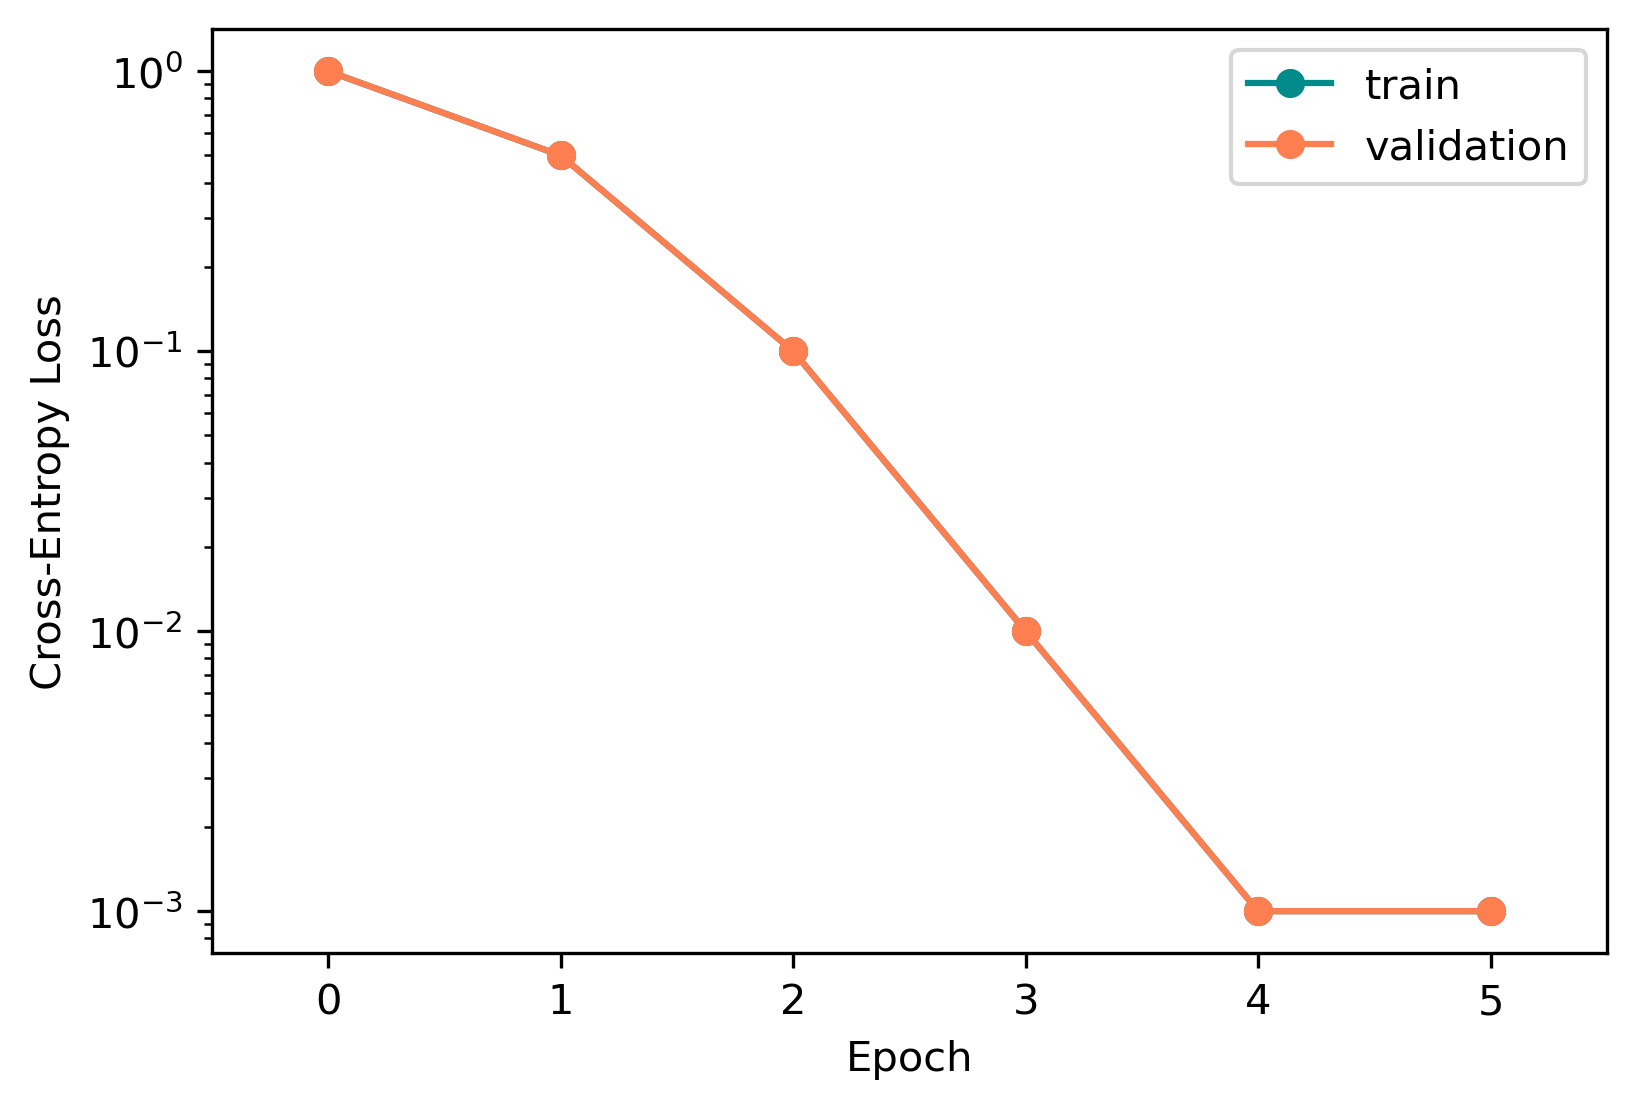

In [16]:
fig, ax = plt.subplots(figsize=(6,4), dpi=300)

ax.plot(times, train_losses, 'o-', c='darkcyan', label='train')
ax.plot(epochs, val_losses, 'o-', c='coral', label='validation')

ax.set_yscale('log')
ax.set_xlim(-0.5, n_epochs+0.5)
ax.set_xlabel('Epoch'); ax.set_ylabel('Cross-Entropy Loss')
ax.legend(loc='upper right')

plt.show()